In [2]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests




class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")
   #new device layout map
   with open(f"./{building}/tabular/double_uniform_device_layout_map_floor_1_2.json") as json_file:
     device_layout_map = json.load(json_file)
   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [4]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

# Train data:
data['observation_value_matrix'] <br />
metadata["observation_ids"]<br />
metadata["observation_timestamps"]<br />
<br />
data['action_value_matrix']<br />
metadata["action_ids"]<br />

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']<br />
metadata_val["action_ids"]<br />
metadata_val["observation_timestamps"]<br />
floorplan
device_layout_map

exogenous_observation_data<br />
exogenous_observation_data_ids<br />
initial_condition

# Predict:
temp_data <br />
temp_data_ids


## Exploratory Data Analysis

In [5]:
data['observation_value_matrix'].shape

(51852, 1198)

In [6]:
data['action_value_matrix'].shape

(51852, 3)

In [7]:
print(data['action_value_matrix'][0], data['action_value_matrix'][3000])

[288.70370483 310.92593384 291.48147583] [290.37036133 352.59259033 291.48147583]


In [8]:
metadata['action_ids']

{'12945159110931775488@supply_air_temperature_setpoint': 0,
 '13761436543392677888@supply_water_temperature_setpoint': 1,
 '14409954889734029312@supply_air_temperature_setpoint': 2}

In [9]:
metadata["observation_ids"]

{'202194278473007104@building_air_static_pressure_setpoint': 0,
 '202194278473007104@building_air_static_pressure_sensor': 1,
 '202194278473007104@outside_air_flowrate_sensor': 2,
 '202194278473007104@exhaust_air_damper_percentage_command': 3,
 '202194278473007104@cooling_percentage_command': 4,
 '202194278473007104@supply_air_temperature_setpoint': 5,
 '202194278473007104@return_air_temperature_sensor': 6,
 '202194278473007104@supply_fan_speed_percentage_command': 7,
 '202194278473007104@supply_fan_speed_frequency_sensor': 8,
 '202194278473007104@mixed_air_temperature_sensor': 9,
 '202194278473007104@supply_air_static_pressure_sensor': 10,
 '202194278473007104@outside_air_flowrate_setpoint': 11,
 '202194278473007104@exhaust_fan_speed_frequency_sensor': 12,
 '202194278473007104@exhaust_fan_speed_percentage_command': 13,
 '202194278473007104@mixed_air_temperature_setpoint': 14,
 '202194278473007104@supply_air_temperature_sensor': 15,
 '202194278473007104@outside_air_damper_percentage_co

In [10]:
initial_condition.shape

(123,)

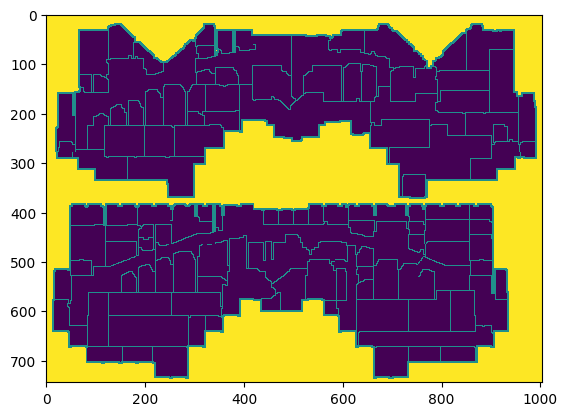

In [11]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [12]:
device_layout_map.keys()

dict_keys(['exterior_space', '1-13', '1-21', '1-46', '1-29', '1-12', '1-20', '1-22', '1-25', '1-28', '1-23', '1-26', '1-15', '1-14', '', '1-17', '1-32', '1-44', '1-43', '1-27', '1-18', '1-16', '1-31', '1-11', '1-10', '1-52', '1-50', '1-19', '1-47', '1-33', '1-09', '1-30', '1-08', '1-07', '1-48', '1-51', '1-34', '1-05', '1-42', '1-53', '1-39', '1-35', '1-04', '1-54', '1-37', '1-03', '1-36', '1-02', '1-55', '1-40', '2-19', '2-20', '2-21', '2-12', '2-22', '2-23', '2-27', '2-28', '2-42', '2-30', '2-31', '2-32', '2-24', '2-25', '2-26', '2-38', '2-33', '2-43', '2-39', '2-16', '2-18', '2-14', '2-40', '2-34', '2-64', '2-13', '2-10', '2-17', '2-37', '2-57', '2-44', '2-5', '2-9', '2-36', '2-8', '2-15', '2-61', '2-46', '2-35', '2-47', '2-7', '2-72', '2-60', '2-48', '2-6', '2-49', '2-65', '2-45', '2-50', '2-4', '2-3', '2-66', '2-59', '2-2', '2-51', '2-58', '2-68', '2-69', '2-67', '2-56', '2-1', '2-71', '2-70', '2-55', '2-54', '2-53', 'unrecognized'])

In [13]:
temp_data.shape

(53292, 123)

## Problem Formualtion

This is a multivariate time-series prediction task. We are

## Dataset Configuration for Models

- Training Data Timeframe: Given time and compute constraints, we will only train on June, 2022 (last month of the training data). This is 8640 timesteps.
- For the Seq2Seq Encoder-Decoder model, at inference time, we will use all 8640 timesteps and autoregressively predict all 2016 timesteps
  - This is not feasible in training. We thus train with sliding windows of 1 day context (encoder length 288) and 1 week prediction (decoder length 144)


### Extract the Desired Data Fields

In [14]:
data_train, metadata_train = data, metadata

temp_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" in k]
temp_data_train = data_train['observation_value_matrix'][:, temp_indexes]
temp_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" in k]
    )
}

exog_train_indexes = [v for k, v in metadata_train['observation_ids'].items()
                if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_train = data_train['observation_value_matrix'][:, exog_train_indexes]
exogenous_observation_data_train_ids = {
    k: i for i, (k, v) in enumerate(
        [(k, v) for k, v in metadata_train['observation_ids'].items()
         if "zone_air_temperature_sensor" not in k]
    )
}

action_data_train = data_train['action_value_matrix']

### Extract the final month (June, 2022) from the training data

In [15]:
train_temp = temp_data_train[-8640:]
train_exog = exogenous_observation_data_train[-8640:]
train_actions = action_data_train[-8640:]


print(train_temp.shape)
print(train_exog.shape)
print(train_actions.shape)

(8640, 123)
(8640, 1075)
(8640, 3)


### Create Dataset for Storing and Accessing the Seq2Seq SB Data

In [16]:
import torch
from torch.utils.data import Dataset
import numpy as np

class SmartBuildingSeq2SeqDataset(Dataset):
    def __init__(self, temp, exog, actions, k=288, n=144, stride=24):
        """
        temp: [T, 123]          - temperature matrix
        exog: [T, 1098]            - exogenous observation matrix
        actions: [T, 3]         - action matrix
        k: input sequence length (encoder)
        n: output sequence length (decoder)
        stride: how far to slide the window
        """
        assert len(temp) == len(exog) == len(actions)
        self.temp = temp
        self.exog = exog
        self.actions = actions
        self.k = k
        self.n = n
        self.stride = stride

        self.samples = []
        for i in range(0, len(temp) - (k + n), stride):
            #Encoder input: concatenate temp, exogenous, action vectors
            enc_x = np.concatenate([
                temp[i:i+k],
                exog[i:i+k],
                actions[i:i+k]
            ], axis=1)

            #Decoder input: vector of size n containing [T_{k-1}, T_k, ..., T_{k+n-2}]
            dec_in = temp[i+k-1:i+k+n-1]

            #Decoder targets: one time-step shifted temperature distributions [T_k, ..., T_{k+n-1}]
            dec_out = temp[i+k:i+k+n]

            dec_exog = exog[i+k:i+k+n]
            dec_actions = actions[i+k:i+k+n]

            self.samples.append((enc_x, dec_in, dec_exog, dec_actions, dec_out))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        enc_x, dec_in, dec_exog, dec_actions, dec_out = self.samples[idx]
        return {
            "encoder_input": torch.tensor(enc_x, dtype=torch.float32),       # [k, 1201 (123 + 1075 + 3)]
            "decoder_input": torch.tensor(dec_in, dtype=torch.float32),     # [n, 123]
            "decoder_exog": torch.tensor(dec_exog, dtype=torch.float32),    # [n, 1075]
            "decoder_actions": torch.tensor(dec_actions, dtype=torch.float32),  # [n, 3]
            "target": torch.tensor(dec_out, dtype=torch.float32),           # [n, 123]
        }


In [17]:
k = 288      # 1 day
n = 144      # 12 hours
stride = 24  # 2-hour step

train_dataset = SmartBuildingSeq2SeqDataset(
    temp=train_temp,
    exog=train_exog,
    actions=train_actions,
    k=k, n=n, stride=stride
)

In [18]:
sample = train_dataset[0]
print("Encoder Input:", sample["encoder_input"].shape)   # [288, 123 + m + 3]
print("Decoder Input:", sample["decoder_input"].shape)   # [144, 123]
print("Target:", sample["target"].shape)  # [144, 123]

Encoder Input: torch.Size([288, 1201])
Decoder Input: torch.Size([144, 123])
Target: torch.Size([144, 123])


## Encoder, Decoder and Seq2Seq Wrapper Classes

Note: We only define the encoder and decoder classes at the cell level, not sequence level

In [19]:
import torch
import torch.nn as nn

class EncoderLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(EncoderLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        #x: [batch size, k, input_dim]
        outputs, (h_n, c_n) = self.lstm(x)
        return h_n, c_n

class DecoderLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=123, num_layers=1):
        super(DecoderLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h_c):
        #x: [batch size, 1, input_dim]
        output, (h, c) = self.lstm(x, h_c)
        pred = self.fc(output.squeeze(1))
        return pred, (h, c)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, encoder_input, decoder_inputs, exog_future, actions_future, teacher_forcing_ratio=1.0):
        """
        encoder_input: [batch, k, 123 + 1098 + 3]
        decoder_inputs: [batch, n, 123]         (ground truth T)
        exog_future:    [batch, n, 1098]
        actions_future: [batch, n, 3]
        """
        batch_size = encoder_input.size(0)
        n = decoder_inputs.size(1)

        outputs = []

        h, c = self.encoder(encoder_input)

        input_t = decoder_inputs[:, 0]

        for t in range(n):
            e_t = exog_future[:, t]
            a_t = actions_future[:, t]

            x_t = torch.cat([input_t, e_t, a_t], dim=1).unsqueeze(1)  # [batch, 1, D]
            pred_t, (h, c) = self.decoder(x_t, (h, c))

            outputs.append(pred_t.unsqueeze(1))  # [batch, 1, 123]

            use_teacher = torch.rand(1).item() < teacher_forcing_ratio
            if t + 1 < n:
                input_t = decoder_inputs[:, t + 1] if use_teacher else pred_t

        return torch.cat(outputs, dim=1)  # [batch, n, 123]


### Training Loop for Seq2Seq Model

Note we use a weighted loss here that combines both standard MSE as well as a smoothless term

In [20]:
import torch
from torch.utils.data import DataLoader

def train_seq2seq_model(model, dataset, num_epochs=100, batch_size=32, lr=1e-3, teacher_forcing_ratio=1.0, device='cuda'):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            encoder_input = batch['encoder_input'].to(device)          # [B, k, D]
            decoder_input = batch['decoder_input'].to(device)          # [B, n, 123]
            decoder_exog = batch['decoder_exog'].to(device)            # [B, n, 1098]
            decoder_actions = batch['decoder_actions'].to(device)      # [B, n, 3]
            target = batch['target'].to(device)                        # [B, n, 123]

            optimizer.zero_grad()

            output = model(
                encoder_input,
                decoder_input,
                decoder_exog,
                decoder_actions,
                teacher_forcing_ratio
            )  # output: [B, n, 123]

            mse_loss = criterion(output, target)
            smoothness_loss = torch.mean((output[:, 1:] - output[:, :-1]) ** 2)

            loss = mse_loss + 0.01 * smoothness_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(dataloader):.5f}")


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
temp_dim = train_temp.shape[1]  # 123
exog_dim = train_exog.shape[1]  # 1098
action_dim = train_actions.shape[1]  # 3
input_dim_encoder = temp_dim + exog_dim + action_dim
input_dim_decoder = temp_dim + exog_dim + action_dim
output_dim = temp_dim

hidden_dim = 256

encoder = EncoderLSTM(input_dim=input_dim_encoder, hidden_dim=hidden_dim)
decoder = DecoderLSTM(input_dim=input_dim_decoder, hidden_dim=hidden_dim, output_dim=output_dim)
model = Seq2Seq(encoder, decoder, device=device)

train_seq2seq_model(
    model=model,
    dataset=train_dataset,
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    teacher_forcing_ratio=1.0,
    device=device
)

Epoch 1/100, Loss: 3898.15791
Epoch 2/100, Loss: 3813.58290
Epoch 3/100, Loss: 3712.20934
Epoch 4/100, Loss: 3582.32344
Epoch 5/100, Loss: 3480.42520
Epoch 6/100, Loss: 3363.72454
Epoch 7/100, Loss: 3256.23118
Epoch 8/100, Loss: 3151.27845
Epoch 9/100, Loss: 3028.71737
Epoch 10/100, Loss: 2922.65754
Epoch 11/100, Loss: 2822.50448
Epoch 12/100, Loss: 2728.13390
Epoch 13/100, Loss: 2624.86315
Epoch 14/100, Loss: 2535.38983
Epoch 15/100, Loss: 2450.70998
Epoch 16/100, Loss: 2358.33109
Epoch 17/100, Loss: 2285.22743
Epoch 18/100, Loss: 2213.44692
Epoch 19/100, Loss: 2128.14008
Epoch 20/100, Loss: 2058.55136
Epoch 21/100, Loss: 1989.61166
Epoch 22/100, Loss: 1922.39545
Epoch 23/100, Loss: 1871.39564
Epoch 24/100, Loss: 1801.75864
Epoch 25/100, Loss: 1736.95391
Epoch 26/100, Loss: 1685.15365
Epoch 27/100, Loss: 1610.34881
Epoch 28/100, Loss: 1570.35112
Epoch 29/100, Loss: 1525.96841
Epoch 30/100, Loss: 1463.66391
Epoch 31/100, Loss: 1413.94971
Epoch 32/100, Loss: 1370.39340
Epoch 33/100, Los

In [23]:
torch.save(model.state_dict(), "seq2seq_model.pt")

## Inference

In [57]:
def autoregressive_forecast(model, encoder_input, initial_condition, exog_future, actions_future, device='cuda'):
    """
    encoder_input: [1, T_enc, 123 + m + 3]
    initial_condition: [123]
    exog_future: [2016, 1098]
    actions_future: [2016, 3]
    """
    model.eval()
    model = model.to(device)

    with torch.no_grad():
        preds = []

        encoder_input = encoder_input.to(device)
        exog_future = exog_future.to(device)
        actions_future = actions_future.to(device)
        input_t = initial_condition.to(device).unsqueeze(0)  #[1, 123]
        preds.append(input_t)

        #Encode full training history
        h, c = model.encoder(encoder_input)

        for t in range(exog_future.shape[0]-1):
            e_t = exog_future[t].unsqueeze(0)     # [1, 1098]
            a_t = actions_future[t].unsqueeze(0)  # [1, 3]

            dec_input = torch.cat([input_t, e_t, a_t], dim=1).unsqueeze(1)  # [1, 1, D]
            pred_t, (h, c) = model.decoder(dec_input, (h, c))               # [1, 123]

            preds.append(pred_t)
            input_t = pred_t

        print(len(preds))
        print(preds[0].shape)
        result = torch.stack([t.squeeze(0) for t in preds])

        print(result.shape)
        return result.cpu()


In [58]:
encoder_input_tensor = torch.tensor(
    np.concatenate([train_temp, train_exog, train_actions], axis=1)[None, :, :],  # [1, 8640, D]
    dtype=torch.float32
)

initial_condition_tensor = torch.tensor(initial_condition, dtype=torch.float32)

exog_future_tensor = torch.tensor(exogenous_observation_data[:2016], dtype=torch.float32)  # [2016, 1098]
actions_future_tensor = torch.tensor(data_val['action_value_matrix'][:2016], dtype=torch.float32)  # [2016, 3]

print(encoder_input_tensor.shape)
print(initial_condition_tensor.shape)
print(exog_future_tensor.shape)
print(actions_future_tensor.shape)

predicted_sequence = autoregressive_forecast(
    model, encoder_input_tensor, initial_condition_tensor,
    exog_future_tensor, actions_future_tensor,
    device='cuda'
)  # [2016, 123]

ground_truth_sequence = torch.tensor(temp_data[:2016], dtype=torch.float32)  # [2016, 123]

torch.Size([1, 8640, 1201])
torch.Size([123])
torch.Size([2016, 1075])
torch.Size([2016, 3])
2016
torch.Size([1, 123])
torch.Size([2016, 123])


In [59]:
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F

def compute_mae(preds, targets):
    return torch.mean(torch.abs(preds - targets))

def compute_kl_divergence(y_pred, y_true, dim=-1, eps=1e-8):
    """
    Compute average KL divergence between predicted and ground truth temperature distributions.

    Args:
        y_pred: Tensor of shape [T, 123] - predicted logits or probabilities
        y_true: Tensor of shape [T, 123] - ground truth logits or probabilities
        dim: Dimension over which to apply softmax (usually -1)
        eps: Small number to prevent log(0)

    Returns:
        Scalar KL divergence (mean over all timesteps)
    """
    p = F.softmax(y_true, dim=dim)
    q = F.softmax(y_pred, dim=dim)

    p = p.clamp(min=eps)
    q = q.clamp(min=eps)

    kl = (p * (p.log() - q.log())).sum(dim=dim)
    return kl.mean()

print(predicted_sequence.shape)
print(ground_truth_sequence.shape)

mae = compute_mae(predicted_sequence, ground_truth_sequence)
print(f"MAE: {mae}")


kl_divergence = compute_kl_divergence(predicted_sequence, ground_truth_sequence)
print(f"KL Divergence: {kl_divergence}")


torch.Size([2016, 123])
torch.Size([2016, 123])
MAE: 15.04179859161377
KL Divergence: 0.15658001601696014


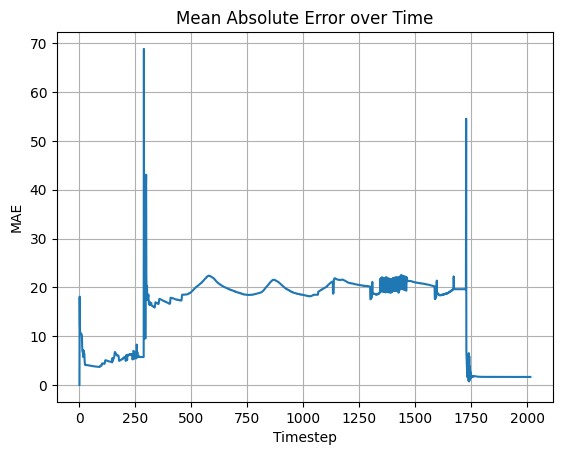

In [60]:
mae_per_timestep = torch.mean(torch.abs(predicted_sequence - ground_truth_sequence), dim=1)

import matplotlib.pyplot as plt

plt.plot(mae_per_timestep)
plt.xlabel("Timestep")
plt.ylabel("MAE")
plt.title("Mean Absolute Error over Time")
plt.grid(True)
plt.show()

In [68]:
ground_truth_sequence[2014]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])

In [67]:
predicted_sequence[2014]

tensor([-1.9606, -2.2972, -2.2460, -1.9279, -0.5368, -4.6495,  0.1187, -0.4215,
        -2.0639, -3.5828, -3.6595,  0.0611, -3.4047,  0.5531, -0.3830, -2.5695,
        -0.4928, -0.4752,  0.1095, -3.2214, -3.9205,  0.4637, -0.6731, -1.4169,
        -3.4343, -1.3714,  0.7507, -0.5575, -3.0976,  0.1183, -1.5258,  0.3702,
         0.0103, -1.0305, -0.7684, -0.1275, -2.0891, -2.0703, -0.6409, -1.7358,
        -0.6071, -2.1568, -2.0912, -0.0584, -1.6659, -3.4225, -0.2380, -2.0309,
        -2.9108, -2.4779, -3.6805,  0.0193, -2.5630,  0.1786,  0.3900,  0.2417,
         0.1802, -0.2814, -1.8959, -0.1307, -0.7205,  0.3526, -4.0845, -2.2849,
        -1.7635, -3.6743, -3.9553, -0.0116, -0.5386, -4.0075,  0.6810, -0.0799,
         0.6741, -1.6764,  0.4865, -3.8163,  0.0520, -3.4335, -3.0647,  0.0589,
        -0.0810, -4.6891,  0.2991, -2.5234, -0.2700, -2.8287, -2.0124, -1.3988,
        -2.9293, -3.4311,  0.0614, -2.2295, -2.6862,  0.1675, -2.2726, -0.1174,
        -3.0950,  0.0724, -2.6278,  0.63